# Convertion rate challenge

Let's participate to a machine learning competition through this project!

- A labelled dataset has been received; this file is used to train the model: make the train/test split, preprocessings, assess performances, try different models, fine-tune hyperparameters.

- An unlabelled dataset has been also received: it will be computed together with the train dataset to make predictions that will be dumped to a csv, and will be used by the organiser of the challenge to assess the model.

This project is about predicting  the behaviour of the users visiting their website: the machine learning model should predict if a given user will subscribe to the newsletter.

This is a classification model, and F1 score will be used to assess the model.

# Content
- 1- import and first exploration
    - 1-1 Basic stats
    - 1-2 EDA
- 2- Preprocessing
- 3- Machine learning models
    - 3-1 Logistic regression
    - 3-2 Random forest classifier
    - 3-3 Adaboost logistic regression
    - 3-4 XGBoost
- 4- Tuning and confusion matrix
    - 4-1 Logistic regression
    - 4-2 XGBoost tuned
    - 4-3 voting LogReg + XGBoost tuned
- 5- Final consolidated picture
- 6- Feature importance of selected model
- 7- Train best classifier to make predictions on X_without_labels
- Conclusion   
    

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1- import "Train" file and first exploration

In [2]:
df = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', df.shape)

Set with labels (our train+test) : (284580, 6)


## 1-1 Basic stats

In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
df_desc = df.describe(include='all')
display(df_desc)
print()

print("Number of missing values: ")
display(df.isna().sum()[df.isna().sum() != 0])

Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Number of missing values: 


Series([], dtype: int64)

- No missing values in this dataset
- the target is "converted"
- we have to look at "age", showing weird max

- The age of 123 years looks weird; let's check the higest ages and get rid of unrealistic values

In [4]:
sorted(df['age'],reverse=True)[:10]

[123, 111, 79, 77, 73, 72, 70, 70, 69, 68]

Let's remove the raws with age = 123 and age = 111

In [5]:
df = df[  (df['age'] != 123) & (df['age'] != 111)  ]

In [6]:
sorted(df['age'],reverse=True)[:10]

[79, 77, 73, 72, 70, 70, 69, 68, 68, 67]

## 1-2 EDA

- Since the dataset is huge we will go ahead on EDA with 10 000 raws (only for EDA)

In [7]:
df_sample = df.sample(10000)

Let's have a look at 
- Is the dataset well balanced?
- Are there any correlations between the features and the target?
- How do the features distribute


### Is the dataset well balanced?

In [8]:
fig = px.pie(df_sample,  names='converted', title= 'Repartition converted vs non converted')
fig.update_traces(pull=[0.3, 0])
fig.show()

The dataset is imbalanced; there will be a risk of overfitting. F1 score will be used and confusion matrix will be necessary to understand what is wrongly predicted.

### Correlations between features and target

In [9]:
# Correlation matrix
corr_matrix = df.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())

fig.show()

- The total number of pages visited has the highest correlation with the target (conversion)
- No other meaningful correlation 

### How do the features distribute according to the target?

In [10]:
# Distribution of each numeric variable according to the target
num_features = ['age', 'total_pages_visited']
for f in num_features:
    fig = px.histogram(df_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    
    fig.show()

Age has almost same graphs with and without conversion. 
Total_pages_visisted is an interesting feature as the distribution is very different depending on the value of Y. Let's dig intos this feature with average conversion by number of pages and by age

- Average conversion by number of pages

In [11]:
data_pages = df_sample.groupby('total_pages_visited')[['converted']].mean() # average convertion by number of pages visited
fig = px.line(data_pages, x= data_pages.index, y= data_pages['converted'], title = 'Conversion vs number of pages visited (average)')
fig.show()

The number of pages visited seems to increase the conversion

- Average conversion by age

In [12]:
data_ages = df_sample.groupby('age')[['converted']].mean()

fig = px.line(data_ages, x= data_ages.index, y= data_ages['converted'], title = 'Conversion vs age (average)')
fig.show()

High level trend on age with conversion decreasing with age, but no lean slope.

### How do the categorical features distribute 

In [13]:
# Histogram of each categorial variable
cat_features = ['country', 'new_user', 'source']
for i in range(len(cat_features)):
    fig = px.histogram(df_sample, x = cat_features[i], y = 'converted')
    fig.show()


- The Chinese users are converting at a significantly lower rate than users from other countries.
- Most people are coming from Seo source. 
- Most converted people are not new users.

- What is the weight of converted in the categorical features?

In [14]:
#Plot histogtram of the source with conversion rate
fig = px.histogram(df_sample, x = 'country', 
                   color = 'converted', 
                   title = '% conversion per country', 
                   barnorm = 'percent'
                    )
fig.show()

In [15]:
#Plot histogtram of the source with conversion rate
fig = px.histogram(df_sample, x = 'new_user', 
                   color = 'converted', 
                   title = '% conversion per user type (new =1)', 
                   barnorm = 'percent'
                    )
fig.show()

In [16]:
#Plot histogtram of the source with conversion rate
fig = px.histogram(df_sample, x = 'source', 
                   color = 'converted', 
                   title = '% conversion per source', 
                   barnorm = 'percent'
                    )
fig.show()

- Germany and UK have the best conversion rates. US is however more represented.
- Not new users have a higher conversion rate.
- Source does not seem to be an important differenciation driver for conversion, since all sources have almost the same conversion rate

### Conclusion of EDA:
- The dataset is imbalanced => Risk of overfitting.  F1 score will be used instead of accuracy, as well as confusion matrix to understand what the model does predict in a wrong way. A stratify will be put in the train/test split as well.
- We know from EDA that the most useful feature is total_pages_visited, let's run the models and confirm this by looking at the feature importance of the best model.

# 2- Preprocessing

In [17]:
# Separate target variable Y from features X

target_variable = "converted"

X = df.drop(target_variable, axis = 1)
Y = df.loc[:,target_variable]

In [18]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['new_user', 'country', 'source'] # where new_user is already encoded

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)

In [20]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [21]:
X_train = preprocessor.fit_transform(X_train)
encoder = LabelEncoder() 
Y_train = encoder.fit_transform(Y_train)
X_test = preprocessor.transform(X_test) 
Y_test = encoder.transform(Y_test)

# 3- Machine learning models

Logistic regression will be used as basic model.
This model is used in classification models to predict the probability distribution accross possible categories. It has coefficient determining how important a variable has a significant impact on the target variable.

## 3-1 Logistic Regression

In [22]:
# Train model
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

LogisticRegression()

In [23]:
train_logreg =classifier.predict(X_train)# calling .predict because need to reach the F1_score
test_logreg = classifier.predict(X_test)
print("f1-score on train set : ", f1_score(train_logreg, Y_train))
print("f1-score on test set : ", f1_score(test_logreg, Y_test ))

f1-score on train set :  0.7625754527162979
f1-score on test set :  0.7711711711711712


In [24]:
scores_logreg = cross_val_score(classifier, X_train, Y_train, scoring="f1", cv=10)
print('train - test = {}'.format(f1_score(train_logreg, Y_train)-f1_score(test_logreg, Y_test )))
print('The standard deviation is : ', scores_logreg.std())

if f1_score(train_logreg, Y_train)-f1_score(test_logreg, Y_test ) < scores_logreg.std():
    print("No overfit of this model")
else:
    print("Overfit of the model!")


train - test = -0.00859571845487328
The standard deviation is :  0.013939226436471592
No overfit of this model


In [25]:
#Creating a df to gather all scores and compare them at the end
scores_df = pd.DataFrame(columns = ['model', 'f1_score', 'set'])

In [26]:
scores_df = scores_df.append({'model': '1-LogReg', 'f1_score': f1_score(train_logreg, Y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': '1-LogReg', 'f1_score': f1_score(test_logreg, Y_test ), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,1-LogReg,0.762575,train
1,1-LogReg,0.771171,test


## 3-2 Random Forest classifier

Random forest is a bagging of random trees. Decision trees are a succession of nodes/branches, splitting into 2 subgroups where a given criteria achieves optimal prediction performance.

In [27]:
# Train model
randomforest = RandomForestClassifier()
randomforest.fit(X_train, Y_train)

RandomForestClassifier()

In [28]:
train_rfc = randomforest.predict(X_train)
test_rfc = randomforest.predict(X_test)
print("f1-score on train set : ", f1_score(train_rfc, Y_train))
print("f1-score on test set : ", f1_score( test_rfc , Y_test))

f1-score on train set :  0.8011163532460628
f1-score on test set :  0.7448194197750148


In [29]:
scores_rfc = cross_val_score(randomforest, X_train, Y_train, scoring="f1", cv=10)
print('train - test = {}'.format(f1_score(train_rfc, Y_train)-f1_score(test_rfc, Y_test )))
print('The standard deviation is : ', scores_rfc.std())

if f1_score(train_rfc, Y_train)-f1_score(test_rfc, Y_test ) < scores_rfc.std():
    print("No overfit of this model")
else:
    print("Overfit of the model!")

train - test = 0.05629693347104803
The standard deviation is :  0.013268991883854062
Overfit of the model!


In [30]:
scores_df = scores_df.append({'model': '2-RFC', 'f1_score': f1_score(train_rfc, Y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': '2-RFC', 'f1_score': f1_score(test_rfc, Y_test ), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,1-LogReg,0.762575,train
1,1-LogReg,0.771171,test
2,2-RFC,0.801116,train
3,2-RFC,0.744819,test


## 3-3- Adaboost logReg

Adaboost is an adaptive boosting model, that is an iterative process, focusing at each iteration by weighting more the wrong predictions, wich leads to adjust better the model at each iteration.

The final classifier is a weighting of all individual classifiers.

In [31]:
# Train model
ada_logistic_regression = LogisticRegression(max_iter = 1000)
adaboost_logreg = AdaBoostClassifier(ada_logistic_regression)
adaboost_logreg.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000))

In [32]:
train_ada_logreg = adaboost_logreg.predict(X_train)
test_ada_logreg = adaboost_logreg.predict(X_test)
print("f1-score on train set : ", f1_score(train_ada_logreg, Y_train))
print("f1-score on test set : ", f1_score( test_ada_logreg , Y_test))

f1-score on train set :  0.7514748762460162
f1-score on test set :  0.754694124772865


In [33]:
scores_ada_logreg = cross_val_score(adaboost_logreg, X_train, Y_train, scoring="f1", cv=10)
print('train - test = {}'.format(f1_score(train_ada_logreg, Y_train)-f1_score(test_ada_logreg, Y_test )))
print('The standard deviation is : ', scores_ada_logreg.std())

if f1_score(train_ada_logreg, Y_train)-f1_score(test_ada_logreg, Y_test ) < scores_ada_logreg.std():
    print("No overfit of this model")
else:
    print("Overfit of the model!")

train - test = -0.00321924852684885
The standard deviation is :  0.013288749919761427
No overfit of this model


In [34]:
scores_df = scores_df.append({'model': '3-Adaboost_logReg', 'f1_score': f1_score(train_ada_logreg, Y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': '3-Adaboost_logReg', 'f1_score': f1_score( test_ada_logreg , Y_test), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,1-LogReg,0.762575,train
1,1-LogReg,0.771171,test
2,2-RFC,0.801116,train
3,2-RFC,0.744819,test
4,3-Adaboost_logReg,0.751475,train
5,3-Adaboost_logReg,0.754694,test


## 3-4- XGBoost

XGBoost is a model with parallel boosted gradient calculations.

A decision tree is built at each step, focusing on the pain points of previous steps. The final model is a weight.

In [35]:
# Train model
xgboost = XGBClassifier()
xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [36]:
train_xgboost = xgboost.predict(X_train)
test_xgboost = xgboost.predict(X_test)
print("f1-score on train set : ", f1_score(train_xgboost, Y_train))
print("f1-score on test set : ", f1_score( test_xgboost , Y_test))

f1-score on train set :  0.7734968670843888
f1-score on test set :  0.7539015606242498


In [37]:
scores_xgboost = cross_val_score(xgboost, X_train, Y_train, scoring="f1", cv=10)
print('train - test = {}'.format(f1_score(train_xgboost, Y_train)-f1_score(test_xgboost, Y_test )))
print('The standard deviation is : ', scores_xgboost.std())

if f1_score(train_xgboost, Y_train)-f1_score(test_xgboost, Y_test ) < scores_xgboost.std():
    print("No overfit of this model")
else:
    print("Overfit of the model!")

train - test = 0.01959530646013896
The standard deviation is :  0.014408542643403499
Overfit of the model!


In [38]:
scores_df = scores_df.append({'model': '4-XGBoost', 'f1_score': f1_score(train_xgboost, Y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': '4-XGBoost', 'f1_score': f1_score( test_xgboost , Y_test), 'set': 'test'}, ignore_index = True)
scores_df

,model,f1_score,set
0,1-LogReg,0.762575,train
1,1-LogReg,0.771171,test
2,2-RFC,0.801116,train
3,2-RFC,0.744819,test
4,3-Adaboost_logReg,0.751475,train
5,3-Adaboost_logReg,0.754694,test
6,4-XGBoost,0.773497,train
7,4-XGBoost,0.753902,test


In [39]:
scores_df = scores_df.sort_values(by = ['set', 'f1_score'], ascending = False)
scores_df

,model,f1_score,set
2,2-RFC,0.801116,train
6,4-XGBoost,0.773497,train
0,1-LogReg,0.762575,train
4,3-Adaboost_logReg,0.751475,train
1,1-LogReg,0.771171,test
5,3-Adaboost_logReg,0.754694,test
7,4-XGBoost,0.753902,test
3,2-RFC,0.744819,test


In [40]:
px.bar(scores_df, x = "model", y = 'f1_score', color = 'set', barmode = 'group', width = 900)

- Before any tuning logistic regression appears to be the best models on test. 

- XGBoost will be the second model retained since the score on train is better than adaboost and let's think there can be imrovement of the test through tuning parameters. It is however overfitting; let's improve models by tuning hyperparameters.

In [41]:
# cleaning of scores_df to use it later on:
mask_scores = (scores_df['model'] == '1-LogReg') | (scores_df['model'] == '4-XGBoost')

scores_df2 = scores_df[mask_scores].reset_index(drop = True)
print(scores_df2)

       model  f1_score    set
0  4-XGBoost  0.773497  train
1   1-LogReg  0.762575  train
2   1-LogReg  0.771171   test
3  4-XGBoost  0.753902   test


# 4- Tuning & Confusion matrix

## 4-1 Logistic Regression

In this exercise, logistic regression does not require tuning since there is no overfitting of the model.
In case of overfitting, a logistic regression model can be tuned with C hyperparameter tuning, per below

C is a penalty that controls trade-off between bias and variance.

In [42]:
# Perform grid search
print("Grid search...")
regressor = LogisticRegression()
# Grid of values to be tested
params = {
    'C': [0.5, 1, 1.2, 1.3] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, scoring='f1', param_grid = params, cv = 10) # cv = 10 because test size defined at 0.1 above
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

Grid search...
...Done.
Best hyperparameters :  {'C': 1}


In [43]:
grid_train_pred = gridsearch.predict(X_train) # .predict takes best parameters from gridsearch above
grid_test_pred = gridsearch.predict(X_test)
print("f1-score on train set : ", f1_score(Y_train, grid_train_pred ))
print("f1-score on test set : ", f1_score(Y_test, grid_test_pred ))

f1-score on train set :  0.7625754527162979
f1-score on test set :  0.7711711711711712


Confusion matrix 

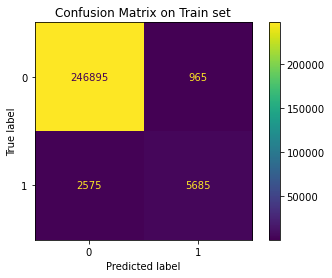

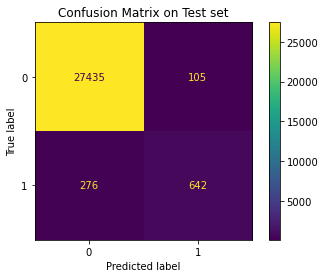

In [44]:
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

The biggest wrongly predicted part are the false negative (True labels = 1 with predicted label = 0).

In this case predicting more false negative than false positive is a more conservative approach and thus is fine with our project.

In [45]:
scores_df2 = scores_df2.append({'model': 'LogReg_tuned', 'f1_score': f1_score(grid_train_pred, Y_train), 'set': 'train'}, ignore_index = True)
scores_df2 = scores_df2.append({'model': 'LogReg_tuned', 'f1_score': f1_score(grid_test_pred, Y_test ), 'set': 'test'}, ignore_index = True)
scores_df2

,model,f1_score,set
0,4-XGBoost,0.773497,train
1,1-LogReg,0.762575,train
2,1-LogReg,0.771171,test
3,4-XGBoost,0.753902,test
4,LogReg_tuned,0.762575,train
5,LogReg_tuned,0.771171,test


## 4-2 XGBoost tuned

### Tuning

Tuning XGBoost can be done on a huge number of hyperparameters

In [46]:
print("Grid search...")
# Grid of values to be tested
params = {
    'max_depth': [3, 4, 5], # max number of successive splits in sub-groups
    'min_child_weight': [3.9, 4.0, 4.1], # minimum number of observation per leaf => limits number of split per node
    'n_estimators': [18, 19, 20], # number of trees built in the model
    'learning_rate': [0.5, 0.6, 0.7], # how fast are the weights updated
}
gridsearch_xgboost = GridSearchCV(xgboost, scoring='f1', param_grid = params, cv = 10) # cv = 10 because test size defined at 0.1 above
gridsearch_xgboost.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgboost.best_params_)

Grid search...
...Done.
Best hyperparameters :  {'learning_rate': 0.6, 'max_depth': 4, 'min_child_weight': 4.0, 'n_estimators': 19}


In [47]:
grid_train_pred_xgboost = gridsearch_xgboost.predict(X_train) 
grid_test_pred_xgboost = gridsearch_xgboost.predict(X_test)
print("f1-score on train set : ", f1_score(grid_train_pred_xgboost, Y_train))
print("f1-score on test set : ", f1_score( grid_test_pred_xgboost, Y_test))

f1-score on train set :  0.7661102613553237
f1-score on test set :  0.767580452920143


In [48]:
scores_xgboost_tuned = cross_val_score(gridsearch_xgboost, X_train, Y_train, scoring="f1", cv=10)
print('train - test = {}'.format(f1_score(grid_train_pred_xgboost, Y_train)-f1_score(grid_test_pred_xgboost, Y_test )))
print('The standard deviation is : ', scores_xgboost_tuned.std())

if f1_score(grid_train_pred_xgboost, Y_train)-f1_score(grid_test_pred_xgboost, Y_test ) < scores_xgboost_tuned.std():
    print("No overfit of this model")
else:
    print("Overfit of the model!")

train - test = -0.001470191564819312
The standard deviation is :  0.01532382238835022
No overfit of this model


### Confusion matrix

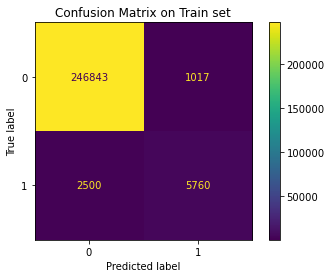

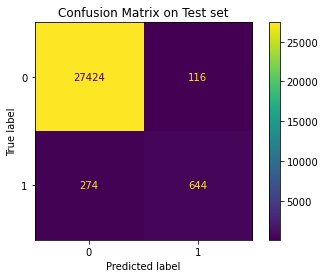

In [49]:
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgboost, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgboost, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

The false negative is the biggest wrongly predicted part.

On the test set the number of false negative and false positive is hardly same as logistic regression model

In [50]:
scores_df2 = scores_df2.append({'model': 'xgboost_tuned', 'f1_score': f1_score(Y_train, grid_train_pred_xgboost), 'set': 'train'}, ignore_index = True)
scores_df2 = scores_df2.append({'model': 'xgboost_tuned', 'f1_score': f1_score(Y_test, grid_test_pred_xgboost), 'set': 'test'}, ignore_index = True)
scores_df2

,model,f1_score,set
0,4-XGBoost,0.773497,train
1,1-LogReg,0.762575,train
2,1-LogReg,0.771171,test
3,4-XGBoost,0.753902,test
4,LogReg_tuned,0.762575,train
5,LogReg_tuned,0.771171,test
6,xgboost_tuned,0.76611,train
7,xgboost_tuned,0.76758,test


## 4-3 voting LogReg + XGBoost tuned

Voting classifier is aggregating models with predictions by weighting the models included: the higher the performance of a model is, the more weight it has, and the worse its performance is, the less weight it will have.

In [51]:
voting = VotingClassifier(estimators=[("logistic", classifier), ("xgboost", gridsearch_xgboost)], voting='soft') # soft: use probabilities for voting
voting.fit(X_train, Y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('xgboost',
                              GridSearchCV(cv=10,
                                           estimator=XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   callbacks=None,
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                          

In [52]:
print("f1_score on training set : ", f1_score(voting.predict(X_train), Y_train ))
print("f1_score on test set : ", f1_score(voting.predict(X_test), Y_test ))

f1_score on training set :  0.7644230769230769
f1_score on test set :  0.7666466706658668


- Evaluation of overfitting is very long to run; since the voting model is less performing on test than xgboost_tuned, the evaluation of overfitting has not been done

In [53]:
scores_df2 = scores_df2.append({'model': 'voting_logreg+xgboost', 'f1_score': f1_score(voting.predict(X_train), Y_train), 'set': 'train'}, ignore_index = True)
scores_df2 = scores_df2.append({'model': 'voting_logreg+xgboost', 'f1_score': f1_score(voting.predict(X_test), Y_test), 'set': 'test'}, ignore_index = True)
scores_df2

,model,f1_score,set
0,4-XGBoost,0.773497,train
1,1-LogReg,0.762575,train
2,1-LogReg,0.771171,test
3,4-XGBoost,0.753902,test
4,LogReg_tuned,0.762575,train
5,LogReg_tuned,0.771171,test
6,xgboost_tuned,0.76611,train
7,xgboost_tuned,0.76758,test
8,voting_logreg+xgboost,0.764423,train
9,voting_logreg+xgboost,0.766647,test


# 5- Final consolidated picture

In [54]:
scores_df2 = scores_df2.sort_values(by = ['set', 'f1_score'], ascending = False)
scores_df2

,model,f1_score,set
0,4-XGBoost,0.773497,train
6,xgboost_tuned,0.76611,train
8,voting_logreg+xgboost,0.764423,train
1,1-LogReg,0.762575,train
4,LogReg_tuned,0.762575,train
2,1-LogReg,0.771171,test
5,LogReg_tuned,0.771171,test
7,xgboost_tuned,0.76758,test
9,voting_logreg+xgboost,0.766647,test
3,4-XGBoost,0.753902,test


In [55]:
px.bar(scores_df2, x = "model", y = 'f1_score', color = 'set', barmode = 'group', width = 900)

- **LogReg and XGBoost tuned** are the 2 best models, with a fairly closed F1 score around 77%. 
- These models have both no overfitting
- XGBoost can be further tuned to find the optimal model.

### **XGBoost_tuned is thus the model retained.**

# 6- Feature importance of selected model

In [56]:
xgboost.feature_importances_

array([0.01782459, 0.68324035, 0.1411116 , 0.0382208 , 0.06969666,
       0.03118816, 0.01101816, 0.00769976], dtype=float32)

In [57]:
preprocessor.transformers_

[('num',
  Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]),
  ['age', 'total_pages_visited']),
 ('cat', OneHotEncoder(drop='first'), ['new_user', 'country', 'source'])]

In [58]:
features_col = []
features_col.extend(preprocessor.transformers_[0][2])
features_col.extend(preprocessor.transformers_[-1][1].get_feature_names_out())
features_col

['age',
 'total_pages_visited',
 'new_user_1',
 'country_Germany',
 'country_UK',
 'country_US',
 'source_Direct',
 'source_Seo']

In [59]:
features_imp = pd.DataFrame(index = features_col, data = xgboost.feature_importances_)
features_graph = features_imp.sort_values(0, ascending = True)
features_graph

,0
source_Seo,0.007700
source_Direct,0.011018
age,0.017825
country_US,0.031188
country_Germany,0.038221
country_UK,0.069697
new_user_1,0.141112
total_pages_visited,0.683240


In [60]:
# Plot coefficients
fig = px.bar(features_graph, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120}, # to avoid cropping of column names
                  height = 600
                 )
fig.show()

In this model the main feature is the number of pages visited; to switch more visitors to converted the bast way is to invest on the quality of the web site

# 7- Train best classifier to make predictions on X_without_labels

let's train our model on ALL the data that was in conversion_data_train.csv

In [61]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch_xgboost.fit(X,Y)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.30000001...
                                     max_cat_threshold=64, max_cat_to_onehot=4,
                                     max_delta_step=0, max_depth=6,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constr

In [62]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [63]:
data_without_labels = preprocessor.transform(data_without_labels)

In [64]:
data = {
    'converted': gridsearch_xgboost.predict(data_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_ElisaV5.csv', index=False)

# Conclusion

**To increase convertion rate**:

Total_pages_visited is by far the most important feature for conversion in the model retained (confirms the assumption we had from EDA).

To convert more people this website needs to invest on quality of the website, enrich the pages, retain attention of visitors.



**Machine learning model improvement:**

XGBoost can be further tuned using more hyperparameters (for example reg_alpha, reg_lambda etc)... knowing that the more parameters the longer to run!
